# Klasifikasi Kupu-kupu

# Model HRNet

## Library

In [19]:
import os
import torch
from torch.utils.data import random_split, DataLoader
from torchvision import datasets, transforms
import timm
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from sklearn.metrics import classification_report

## Load Data

In [21]:
# from google.colab import drive
# drive.mount('/content/drive')

In [22]:
dataset_path = "/content/kupu"

## Preprocessing

In [23]:
# Transform data
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [24]:
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
print(f"Dataset Size: {len(dataset)}")

Dataset Size: 800


In [25]:
# Membagi dataset menjadi train dan test
train_size = int(0.8 * len(dataset))  # 80% untuk training
test_size = len(dataset) - train_size  # 20% untuk testing
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [26]:
# DataLoader untuk train dan test
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [27]:
# Label mapping
label_map = dataset.class_to_idx
print(f"Label Mapping: {label_map}")

Label Mapping: {'kupu_batik_cap': 0, 'kupu_harimau_kuning_hijau': 1, 'kupu_hijau_biru': 2, 'kupu_jarak': 3, 'kupu_jojo': 4, 'kupu_pantat_merah': 5, 'kupu_raja_helena': 6, 'kupu_raja_limau': 7}


## Modelling

In [ ]:
# Muat model HRNet pre-trained
model = timm.create_model('hrnet_w18', pretrained=True)

In [ ]:
# Jumlah Kelas
num_classes = len(label_map)
model.fc = nn.Linear(model.num_features, num_classes)

In [ ]:
# Pindahkan model ke device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
# Optimizer
criterion = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-4)

In [ ]:
def train_model(model, train_loader, test_loader, optimizer, criterion, device, num_epochs=5):
    train_losses = []
    test_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_loss = total_loss / len(train_loader)
        train_accuracy = correct / total * 100
        train_losses.append(train_loss)

        test_accuracy, precision, recall, f1 = evaluate_model(model, test_loader, device)
        test_accuracies.append(test_accuracy)

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss:.4f}, "
              f"Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%")

    return train_losses, test_accuracies

In [ ]:
def evaluate_model(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total * 100
    report = classification_report(all_labels, all_predictions, target_names=list(label_map.keys()), output_dict=True)
    precision = report['macro avg']['precision']
    recall = report['macro avg']['recall']
    f1 = report['macro avg']['f1-score']

    return accuracy, precision, recall, f1

In [ ]:
num_epochs = 5
train_losses, test_accuracies = train_model(
    model, train_loader, test_loader, optimizer, criterion, device, num_epochs)

Epoch 1/5, Loss: 1.3439, Train Accuracy: 83.91%, Test Accuracy: 100.00%
Epoch 2/5, Loss: 0.0221, Train Accuracy: 99.69%, Test Accuracy: 100.00%
Epoch 3/5, Loss: 0.0148, Train Accuracy: 99.84%, Test Accuracy: 100.00%
Epoch 4/5, Loss: 0.0092, Train Accuracy: 99.84%, Test Accuracy: 100.00%
Epoch 5/5, Loss: 0.0031, Train Accuracy: 100.00%, Test Accuracy: 100.00%


In [ ]:
model_save_path = "/content/hrnet_model.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to /content/hrnet_model.pth


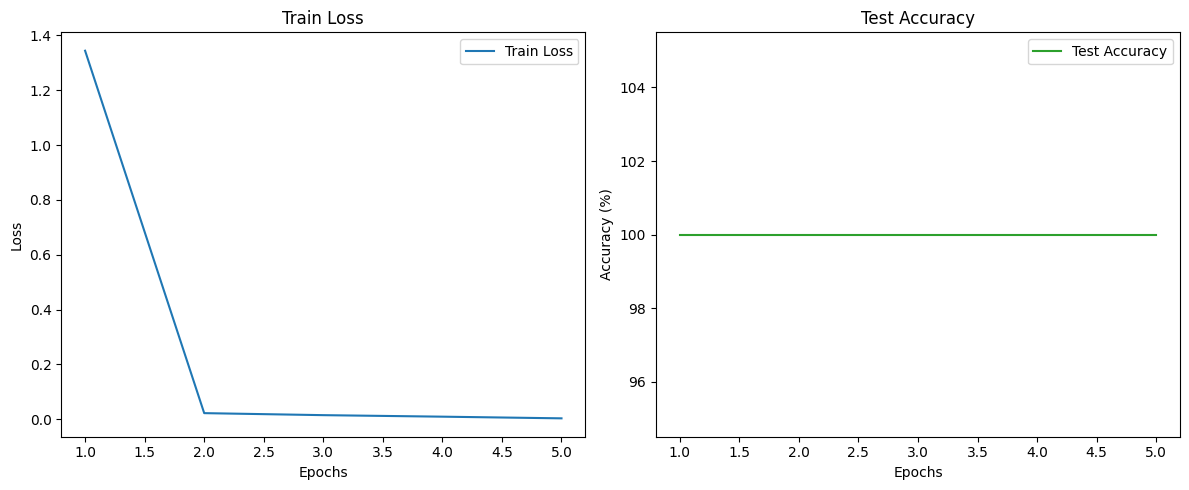

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(range(1, num_epochs + 1), train_losses, color='tab:blue', label='Train Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Train Loss')
ax1.legend()

ax2.plot(range(1, num_epochs + 1), test_accuracies, color='tab:green', label='Test Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Test Accuracy')
ax2.legend()

fig.tight_layout()

plt.show()


In [ ]:
final_accuracy, final_precision, final_recall, final_f1 = evaluate_model(model, test_loader, device)

print(f"Final Test Accuracy: {final_accuracy:.2f}%")
print(f"Final Precision: {final_precision:.2f}%")
print(f"Final Recall: {final_recall:.2f}%")
print(f"Final F1-Score: {final_f1:.2f}%")

Final Test Accuracy: 100.00%
Final Precision: 1.00%
Final Recall: 1.00%
Final F1-Score: 1.00%


# Model ConvNeXt

## Library

In [4]:
!unzip kupu.zip

Archive:  kupu.zip
   creating: kupu/
   creating: kupu/kupu_batik_cap/
  inflating: kupu/kupu_batik_cap/Kupu Batik Cap-1.JPG  
  inflating: kupu/kupu_batik_cap/Kupu Batik Cap-10.JPG  
  inflating: kupu/kupu_batik_cap/Kupu Batik Cap-100.jpg  
  inflating: kupu/kupu_batik_cap/Kupu Batik Cap-11.JPG  
  inflating: kupu/kupu_batik_cap/Kupu Batik Cap-12.JPG  
  inflating: kupu/kupu_batik_cap/Kupu Batik Cap-13.JPG  
  inflating: kupu/kupu_batik_cap/Kupu Batik Cap-14.JPG  
  inflating: kupu/kupu_batik_cap/Kupu Batik Cap-15.JPG  
  inflating: kupu/kupu_batik_cap/Kupu Batik Cap-16.JPG  
  inflating: kupu/kupu_batik_cap/Kupu Batik Cap-17.JPG  
  inflating: kupu/kupu_batik_cap/Kupu Batik Cap-18.jpg  
  inflating: kupu/kupu_batik_cap/Kupu Batik Cap-19.jpg  
  inflating: kupu/kupu_batik_cap/Kupu Batik Cap-2.JPG  
  inflating: kupu/kupu_batik_cap/Kupu Batik Cap-20.jpg  
  inflating: kupu/kupu_batik_cap/Kupu Batik Cap-21.jpg  
  inflating: kupu/kupu_batik_cap/Kupu Batik Cap-22.JPG  
  inflating: kupu

In [36]:
import timm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset
from PIL import Image
import os

## Preprocessing

In [37]:
class CustomImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_labels = []
        self.image_paths = []

        for label in os.listdir(image_dir):
            label_path = os.path.join(image_dir, label)
            if os.path.isdir(label_path):
                for filename in os.listdir(label_path):
                    self.image_paths.append(os.path.join(label_path, filename))
                    self.image_labels.append(label)

        # Konversi label menjadi angka
        self.label_encoder = LabelEncoder()
        self.image_labels = self.label_encoder.fit_transform(self.image_labels)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert('RGB')
        label = self.image_labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

In [38]:
image_dir = '/content/kupu'

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [39]:
dataset = CustomImageDataset(image_dir, transform)
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

## Modelling

In [40]:
model = timm.create_model('convnext_tiny', pretrained=True)
num_classes = len(set(dataset.image_labels))
model.head.fc = nn.Linear(model.num_features, num_classes)

In [41]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [42]:
num_epochs = 5
train_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Evaluasi
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = (correct / total) * 100
    test_accuracies.append(test_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {test_accuracy:.2f}%')

Epoch [1/5], Loss: 3.3957, Accuracy: 8.12%
Epoch [2/5], Loss: 2.1519, Accuracy: 13.12%
Epoch [3/5], Loss: 2.1067, Accuracy: 9.38%
Epoch [4/5], Loss: 2.0778, Accuracy: 8.12%
Epoch [5/5], Loss: 2.1655, Accuracy: 8.12%


In [43]:
model_save_path = "/content/convnext_model.pth"

torch.save(model.state_dict(), model_save_path)

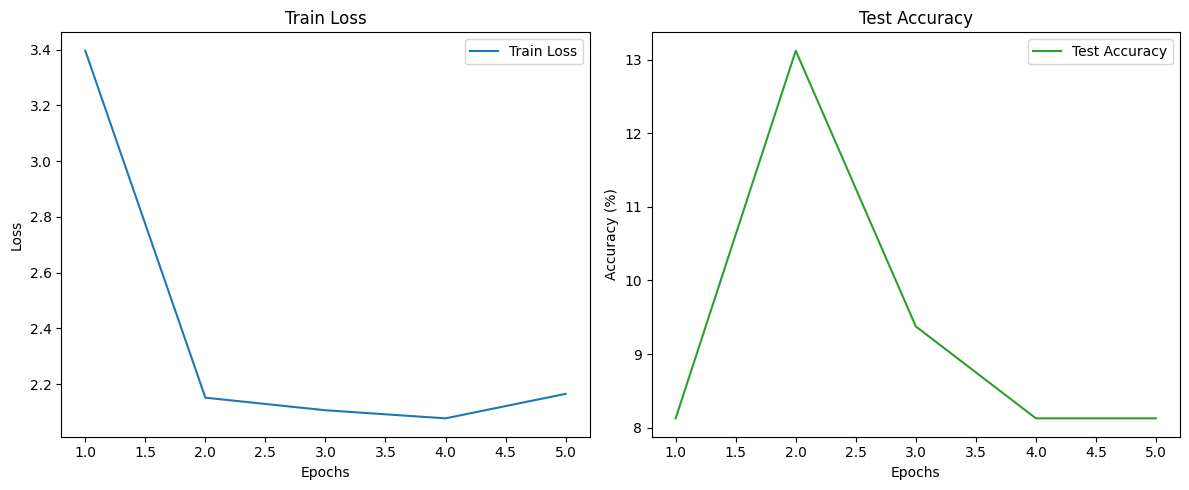

In [44]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(range(1, num_epochs + 1), train_losses, color='tab:blue', label='Train Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Train Loss')
ax1.legend()

ax2.plot(range(1, num_epochs + 1), test_accuracies, color='tab:green', label='Test Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Test Accuracy')
ax2.legend()

fig.tight_layout()

plt.show()

In [46]:
def evaluate_model(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total * 100
    report = classification_report(all_labels, all_predictions, target_names=list(label_map.keys()), output_dict=True)
    precision = report['macro avg']['precision']
    recall = report['macro avg']['recall']
    f1 = report['macro avg']['f1-score']

    return accuracy, precision, recall, f1

In [49]:
import warnings
warnings.filterwarnings('ignore')

final_accuracy, final_precision, final_recall, final_f1 = evaluate_model(model, test_loader, device)

print(f"Final Test Accuracy: {final_accuracy:.2f}%")
print(f"Final Precision: {final_precision:.2f}%")
print(f"Final Recall: {final_recall:.2f}%")
print(f"Final F1-Score: {final_f1:.2f}%")

Final Test Accuracy: 8.12%
Final Precision: 0.01%
Final Recall: 0.12%
Final F1-Score: 0.02%


# Swin Transformer

In [62]:
model_swin = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True)
num_classes = len(set(dataset.image_labels))
model_swin.head = nn.Linear(model_swin.num_features, num_classes)

In [63]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_swin.parameters(), lr=0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_swin = model_swin.to(device)

In [64]:
num_epochs = 5
train_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        # Get the class predictions by taking the maximum value along the class dimension (dim=1)
        _, predicted = torch.max(outputs.data, 1)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Evaluation phase
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            # Get the class predictions for evaluation
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_accuracy = (correct / total) * 100
    test_accuracies.append(test_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {test_accuracy:.2f}%')

OutOfMemoryError: CUDA out of memory. Tried to allocate 38.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 19.06 MiB is free. Process 9048 has 14.73 GiB memory in use. Of the allocated memory 13.97 GiB is allocated by PyTorch, and 633.92 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)